In [1]:
# gym import only.
# Note: No rendering required for this deliverable.
import gym
# utility import packages
import random
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
# visualization import
import matplotlib.pyplot as plt

In [2]:
env = gym.make('MountainCar-v0')
env.reset()
goal_steps = 200
score_requirement = -198
intial_games = 8000 # running 8K games to learn the agents behavior.

In [3]:
def model_data_preparation(reward_threshold=-0.99):
    training_data = []
    accepted_scores = []
    for game_index in range(intial_games):
        score = 0
        game_memory = []
        previous_observation = [] # it stores previous pos, vel observation data.
        for step_index in range(goal_steps):
            action = random.randrange(0, 3)
            observation, reward, done, info = env.step(action)
            # Essentially, we are taking (s(t-1), a(t)) tuple and 
            # evaluating whether our new reward function gives positive reward.
            
            # With this our model learns to take appropriate actions based on
            # previous state and predict current action that needs to be taken.
            if len(previous_observation) > 0:
                game_memory.append([previous_observation, action])   
            previous_observation = observation
            if observation[0] > reward_threshold:
                # Plotting Average Reward values as per the variations in
                reward = 1
            
            score += reward
            if done:
                break
            
        if score >= score_requirement:
            accepted_scores.append(score)
            for data in game_memory:
                # one-hot encoding the actions taken.
                if data[1] == 1:
                    output = [0, 1, 0]
                elif data[1] == 0:
                    output = [1, 0, 0]
                elif data[1] == 2:
                    output = [0, 0, 1]
                training_data.append([data[0], output])
        
        env.reset()
    
    print('Training data generated for Reward Threshold: '+str(reward_threshold)+' | Game Iteration Number: '+str(game_index)+' | Accepted Game Scores: '+str(accepted_scores))
    return training_data

In [4]:
# Defining the model structure for training.
def build_model(input_size, output_size):
    model = Sequential()
    model.add(Dense(128, input_dim=input_size, activation='relu'))
    model.add(Dense(52, activation='relu'))
    model.add(Dense(output_size, activation='linear'))
    model.compile(loss='mse', optimizer=Adam())
    return model

In [5]:
# function for training the model.
def train_model(training_data):
    X = np.array([i[0] for i in training_data]).reshape(-1, len(training_data[0][0]))
    y = np.array([i[1] for i in training_data]).reshape(-1, len(training_data[0][1]))
    model = build_model(input_size=len(X[0]), output_size=len(y[0]))
    model.fit(X, y, epochs=5)
    return model

In [6]:
def eval_agent(trained_model=None):
    scores = []
    choices = []
    for each_game in range(100):
        score = 0
        prev_obs = []
        for step_index in range(goal_steps):
            if len(prev_obs)==0:
                action = random.randrange(0,2)
            else:
                # predicting the next action based on the redefined reward function
                # in the environment.
                action = np.argmax(trained_model.predict(prev_obs.reshape(-1, len(prev_obs)))[0])
        
            choices.append(action)
            new_observation, reward, done, info = env.step(action)
            prev_obs = new_observation
            score+=reward
            if done:
                break
        env.reset()
        scores.append(score)
    print('Corresponding reward value scores: '+ str(scores))
    average_reward = (sum(scores)/len(scores))
    choice_one = choices.count(1)/len(choices)
    choice_zero = choices.count(0)/len(choices)
    choice_two = choices.count(2)/len(choices)
    print((average_reward, choice_one, choice_zero, choice_two))
    return average_reward, choice_one, choice_zero, choice_two

In [7]:
reward_thresholds = np.linspace(-0.30, -0.15, 20)

In [8]:
average_reward_values = []
choices_one = []
choices_zero = []
choices_two  = []

In [9]:
# Each iteration capturing different result parameters for the plot
for reward_thres in reward_thresholds:
    print('Training data preparation started for position reward threshold value: '+str(reward_thres))
    training_data = model_data_preparation(reward_thres)
    print('Training data generation process is finished. Starting agent training process.')
    trained_model = train_model(training_data)
    print('Model training process is finished. Starting agent evaluation process.')
    average_reward, choice_one, choice_zero, choice_two = eval_agent(trained_model)
    average_reward_values.append(average_reward)
    choices_one.append(choice_one)
    choices_zero.append(choice_zero)
    choices_two.append(choice_two)
    print('Agent evaluation process has finished for position reward threshold value: '+str(reward_thres))

Training data preparation started for position reward threshold value: -0.3
Training data generated for Reward Threshold: -0.3 | Game Iteration Number: 7999 | Accepted Game Scores: [-188.0, -176.0, -172.0, -186.0, -180.0, -160.0, -162.0, -188.0, -180.0, -184.0, -160.0, -178.0, -150.0, -184.0, -186.0, -180.0, -182.0, -168.0, -166.0, -182.0, -170.0, -180.0, -182.0, -176.0, -190.0, -180.0, -192.0, -184.0, -180.0, -180.0, -162.0, -178.0, -174.0, -174.0, -170.0, -160.0, -172.0, -192.0, -174.0, -176.0, -188.0, -182.0, -192.0, -172.0, -188.0, -166.0, -184.0, -172.0, -182.0, -176.0, -188.0, -178.0, -128.0, -188.0, -168.0, -176.0, -168.0, -176.0, -176.0, -174.0, -172.0, -176.0, -184.0, -172.0, -176.0, -184.0, -148.0, -184.0, -178.0, -164.0, -190.0, -190.0, -184.0, -176.0, -178.0, -170.0, -174.0, -188.0, -182.0, -190.0, -160.0, -182.0, -184.0, -178.0, -178.0, -160.0, -168.0, -154.0, -138.0, -182.0, -174.0, -166.0, -172.0, -168.0, -196.0, -164.0, -174.0, -190.0, -166.0, -174.0, -164.0, -176.0, -1

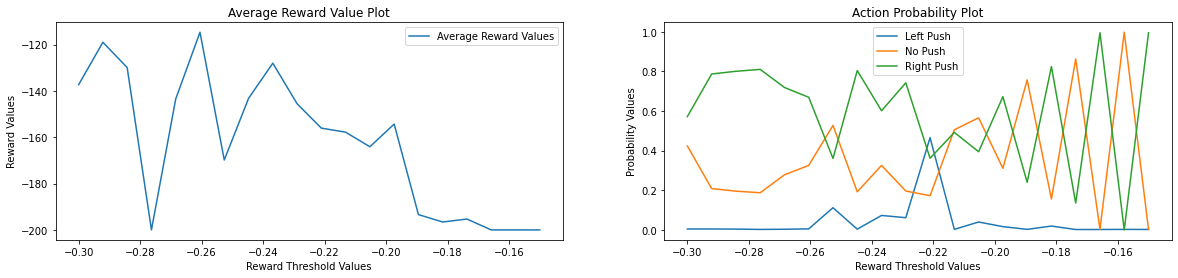

In [13]:
# Plotting the results after modelling training completion
fig = plt.figure(figsize=(20,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.plot(reward_thresholds, average_reward_values, label='Average Reward Values')
ax2.plot(reward_thresholds, choices_one, label='Left Push')
ax2.plot(reward_thresholds, choices_zero, label='No Push')
ax2.plot(reward_thresholds, choices_two, label='Right Push')

ax1.set_xlabel('Reward Threshold Values')
ax1.set_ylabel('Reward Values')
ax1.set_title('Average Reward Value Plot')
ax1.legend()

ax2.set_xlabel('Reward Threshold Values')
ax2.set_ylabel('Probability Values')
ax2.set_title('Action Probability Plot')
ax2.legend()

plt.show()

In [10]:
# Above graphs have lots of insights in them that can be used to create even more
# meaningful later iteration of experiment. Which one did you found most interesting ?